In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

### Step 1: Read the dataset

In [2]:
import pandas as pd

df = pd.read_csv('train.csv')

df.head()

,id,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


### Step 2: Perform basic data quality checks

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   136429 non-null  int64  
 1   Product ID           136429 non-null  object 
 2   Type                 136429 non-null  object 
 3   Air temperature      136429 non-null  float64
 4   Process temperature  136429 non-null  float64
 5   Rotational speed     136429 non-null  int64  
 6   Torque               136429 non-null  float64
 7   Tool wear            136429 non-null  int64  
 8   Machine failure      136429 non-null  int64  
 9   TWF                  136429 non-null  int64  
 10  HDF                  136429 non-null  int64  
 11  PWF                  136429 non-null  int64  
 12  OSF                  136429 non-null  int64  
 13  RNF                  136429 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 14.6+ MB


In [4]:
df.isna().sum()

id                     0
Product ID             0
Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Machine failure        0
TWF                    0
HDF                    0
PWF                    0
OSF                    0
RNF                    0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

### Step 3: Seperate X and Y (MachineFailure)

In [6]:
X = df.drop(columns=['id', 'Product ID', 'Machine failure'])
Y = df[['Machine failure']]

In [7]:
X.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,TWF,HDF,PWF,OSF,RNF
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0


In [8]:
Y.head()

,Machine failure
0,0
1,0
2,0
3,0
4,0


In [9]:
Y.value_counts()

Machine failure
0                  134281
1                    2148
Name: count, dtype: int64

<Axes: xlabel='Machine failure'>

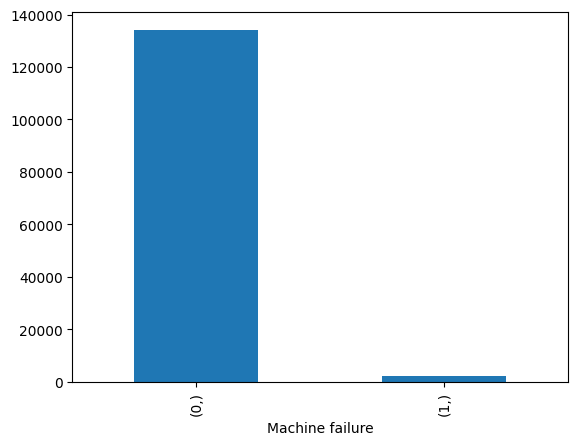

In [10]:
Y.value_counts().plot( kind='bar' )

### Step 4 : Perform preprocessing on X

In [11]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [12]:
cat

['Type']

In [13]:
con

['Air temperature',
 'Process temperature',
 'Rotational speed',
 'Torque',
 'Tool wear',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [15]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

In [16]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]).set_output(transform= 'pandas')

In [17]:
pre = ColumnTransformer([('num', num_pipe, con), ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [18]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Air temperature,num__Process temperature,num__Rotational speed,num__Torque,num__Tool wear,num__TWF,num__HDF,num__PWF,num__OSF,num__RNF,cat__Type_H,cat__Type_L,cat__Type_M
0,0.395880,-0.246230,0.545416,-0.499711,0.556417,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
1,1.469856,1.558605,1.720308,-1.323028,1.494433,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0
2,-0.302204,-1.040358,2.051873,-1.628831,-1.241447,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
3,0.610675,0.692284,0.026445,0.464745,1.447532,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
4,-1.000288,-0.679391,0.869773,-0.582043,-1.100744,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0


### Step 5: Apply train test split

In [19]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=21)

In [20]:
xtrain.head()

,num__Air temperature,num__Process temperature,num__Rotational speed,num__Torque,num__Tool wear,num__TWF,num__HDF,num__PWF,num__OSF,num__RNF,cat__Type_H,cat__Type_L,cat__Type_M
29391,-0.194806,0.620091,-0.225832,-0.017483,-0.506668,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
111006,0.073688,1.053251,0.372426,-0.546758,1.259929,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
16102,0.288483,0.475704,-0.658308,0.770549,1.338097,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
110599,1.040265,0.764477,0.985100,-0.864323,0.228111,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0
84638,2.114241,2.280539,-0.506942,0.323605,-0.303431,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0


In [21]:
xtest.head()

,num__Air temperature,num__Process temperature,num__Rotational speed,num__Torque,num__Tool wear,num__TWF,num__HDF,num__PWF,num__OSF,num__RNF,cat__Type_H,cat__Type_L,cat__Type_M
22333,1.684651,1.702992,-0.283496,-0.240955,0.071775,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0
35216,1.953144,1.558605,3.068191,-2.263961,0.149943,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
112970,1.308759,0.836671,-0.622268,2.146663,-0.131461,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0
14905,0.664374,0.331317,0.466129,-0.511473,-0.209629,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,1.0,0.0,0.0
25676,1.308759,1.269831,4.949460,-2.863806,-1.085111,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,1.0,0.0,0.0


In [22]:
ytrain.head()

,Machine failure
29391,0
111006,0
16102,0
110599,0
84638,0


In [23]:
ytest.head()

,Machine failure
22333,0
35216,0
112970,0
14905,0
25676,0


In [24]:
xtrain.shape

(109143, 13)

In [25]:
xtest.shape

(27286, 13)

### Step 6 : Algorithm Evaluation

In [26]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

In [28]:
dct = {
    "Logistic" : LogisticRegression(),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "Gradient Boost": GradientBoostingClassifier(),
    "XGBoost" : xgb.XGBClassifier()
 }

In [29]:
dct.items()

dict_items([('Logistic', LogisticRegression()), ('Decision Tree', DecisionTreeClassifier()), ('Random Forest', RandomForestClassifier()), ('Gradient Boost', GradientBoostingClassifier()), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...))])

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [31]:
# Initialize train, test and cv scores blank list
train = []
test = []
train_cv = []
# Apply for loop on the models
for name, model in dct.items():
    # Train the model
  
    model.fit(xtrain, ytrain)
    
    # Predict the results for train and test
    ypred_train = model.predict(xtrain)
    ypred_test = model.predict(xtest)
    # Calculate f1 score for train and test
    train_f1 = f1_score(ytrain, ypred_train, average='macro')
    test_f1 = f1_score(ytest, ypred_test, average='macro')
    # Calculate 5 fold cv score for data
    scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring='f1_macro')
    cv = float(scores.mean())
    # Append above values in the list
    train.append(train_f1)
    test.append(test_f1)
    train_cv.append(cv)
    # Print the results
    print(f"Model Name : {name}\n")
    print(f"Train F1 Macro : {train_f1:.4f}")
    print(f"Test F1 Macro : {test_f1:.4f}")
    print(f"Train 5 Fold CV F1 Macro : {cv:.4f} ")
    print("\n==================================================\n")

Model Name : Logistic

Train F1 Macro : 0.9318
Test F1 Macro : 0.9260
Train 5 Fold CV F1 Macro : 0.9310 


Model Name : Decision Tree

Train F1 Macro : 0.9978
Test F1 Macro : 0.8790
Train 5 Fold CV F1 Macro : 0.8756 


Model Name : Random Forest

Train F1 Macro : 0.9975
Test F1 Macro : 0.9287
Train 5 Fold CV F1 Macro : 0.9297 


Model Name : Gradient Boost

Train F1 Macro : 0.9358
Test F1 Macro : 0.9260
Train 5 Fold CV F1 Macro : 0.9284 


Model Name : XGBoost

Train F1 Macro : 0.9467
Test F1 Macro : 0.9245
Train 5 Fold CV F1 Macro : 0.9284 




### Create dataframe and show results in tabular format

In [32]:
results = {
    'name' : list(dct.keys()),
    'train_f1' : train,
    'test_f1' : test,
    'train_cv' : train_cv
}

In [33]:
results_df = pd.DataFrame(results)
results_df

,name,train_f1,test_f1,train_cv
0,Logistic,0.931790,0.926034,0.931022
1,Decision Tree,0.997775,0.878970,0.875559
2,Random Forest,0.997486,0.928704,0.929675
3,Gradient Boost,0.935824,0.926034,0.928385
4,XGBoost,0.946663,0.924528,0.928369


In [34]:
results_df.sort_values(by='train_cv', ascending=False)

,name,train_f1,test_f1,train_cv
0,Logistic,0.931790,0.926034,0.931022
2,Random Forest,0.997486,0.928704,0.929675
3,Gradient Boost,0.935824,0.926034,0.928385
4,XGBoost,0.946663,0.924528,0.928369
1,Decision Tree,0.997775,0.878970,0.875559


### From the above Logistic regression model has best f1_macro cross validated score of 0.931022

In [37]:
best_model = LogisticRegression()
best_model.fit(xtrain, ytrain)

LogisticRegression()

In [38]:
best_model.score(xtrain, ytrain)

0.9962434604143189

In [39]:
best_model.score(xtest,ytest)

0.9959686286007476

### Evaluating selected model

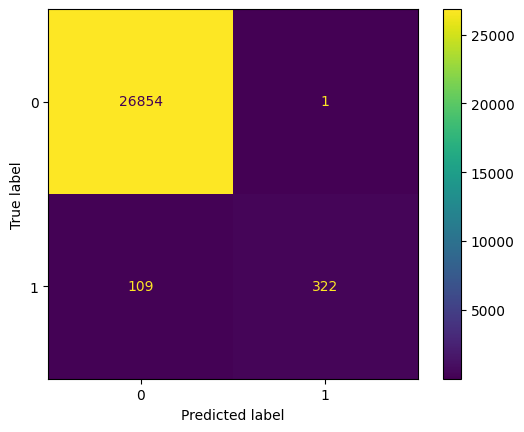

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, xtest, ytest)

In [41]:
#Predict the result for train and test 
ypred_train = best_model.predict(xtrain)
ypred_test = best_model.predict(xtest)

In [42]:
ypred_test[0:5]

array([0, 0, 0, 0, 0])

In [43]:
ytest.head()

,Machine failure
22333,0
35216,0
112970,0
14905,0
25676,0


In [44]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26855
           1       1.00      0.75      0.85       431

    accuracy                           1.00     27286
   macro avg       1.00      0.87      0.93     27286
weighted avg       1.00      1.00      1.00     27286



### Plot ROC (Receiver Operator Characteristics) AUC (Area Under Curve)

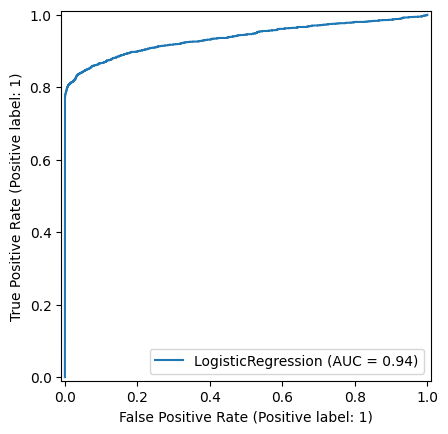

In [45]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_model, xtrain, ytrain)

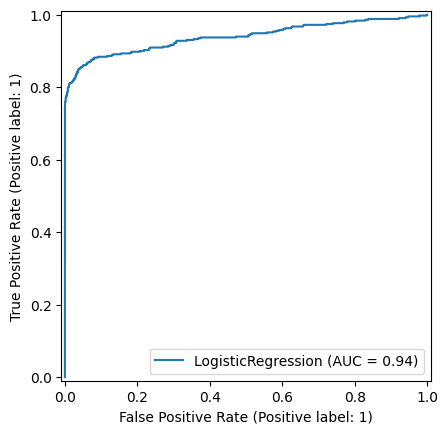

In [46]:
RocCurveDisplay.from_estimator(best_model, xtest, ytest)

In [47]:
roc_scores = cross_val_score(best_model, xtrain, ytrain, cv=5, scoring='roc_auc')
roc_scores

array([0.93640866, 0.9212189 , 0.93222624, 0.94507029, 0.94139243])

In [49]:
roc_scores.mean()

np.float64(0.9352633043987055)

In [50]:
roc_scores_test = cross_val_score(best_model, xtest, ytest, cv=5, scoring='roc_auc')
roc_scores_test

array([0.90695455, 0.94352314, 0.96165237, 0.94379917, 0.93877326])

In [51]:
roc_scores_test.mean()

np.float64(0.9389404974719691)

### Because cross validated ROC AUC score for train in more than 0.8 hence it is good model

### Out of sample predictiions

In [55]:
xnew = pd.read_csv('test.csv')
xnew.head()

,id,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [56]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Air temperature', 'Process temperature',
                                  'Rotational speed', 'Torque', 'Tool wear',
                                  'TWF', 'HDF', 'PWF', 'OSF', 'RNF']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Type'])])

In [57]:
xnew_pre = pre.transform(xnew)
xnew_pre

,num__Air temperature,num__Process temperature,num__Rotational speed,num__Torque,num__Tool wear,num__TWF,num__HDF,num__PWF,num__OSF,num__RNF,cat__Type_H,cat__Type_L,cat__Type_M
0,1.308759,1.125444,-0.153753,-0.276240,-0.694271,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
1,0.986567,0.764477,1.388744,-1.358313,-1.366516,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
2,0.771772,0.331317,0.033653,-0.311525,-0.131461,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
3,0.127386,-0.246230,-0.297912,0.852880,-1.554119,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0
4,1.899446,1.702992,-0.038426,0.111895,0.149943,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,1.308759,1.053251,-0.261872,0.006040,-1.397783,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
90950,-1.053986,-0.101844,0.156188,-0.770229,-1.147645,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
90951,-2.289058,-2.700806,-0.139337,0.123657,1.291196,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0
90952,-0.946589,-1.545712,0.098524,-0.005721,-0.553568,-0.03945,-0.072021,-0.049016,-0.063038,-0.047568,0.0,1.0,0.0


In [58]:
preds = best_model.predict(xnew_pre)
probs = best_model.predict_proba(xnew_pre)

In [59]:
preds[0:5]

array([0, 0, 0, 0, 0])

In [60]:
model.classes_

array([0, 1])

In [61]:
probs[0:5]

array([[0.99763872, 0.00236128],
       [0.99869815, 0.00130185],
       [0.99713481, 0.00286519],
       [0.99656312, 0.00343688],
       [0.99630171, 0.00369829]])

In [62]:
prob_failure = probs[:, 1]
prob_failure[0:5]

array([0.00236128, 0.00130185, 0.00286519, 0.00343688, 0.00369829])

In [63]:
df_final = xnew[['id']]
df_final

,id
0,136429
1,136430
2,136431
3,136432
4,136433
...,...
90949,227378
90950,227379
90951,227380
90952,227381


In [64]:
df_final['MachineFailure_pred'] = preds
df_final['Prob_MachineFailure'] = prob_failure

In [65]:
df_final

,id,MachineFailure_pred,Prob_MachineFailure
0,136429,0,0.002361
1,136430,0,0.001302
2,136431,0,0.002865
3,136432,0,0.003437
4,136433,0,0.003698
...,...,...,...
90949,227378,0,0.002605
90950,227379,0,0.000536
90951,227380,0,0.003029
90952,227381,0,0.002728


In [66]:
df_final['MachineFailure_pred'].value_counts()

MachineFailure_pred
0    89849
1     1105
Name: count, dtype: int64

<Axes: xlabel='MachineFailure_pred'>

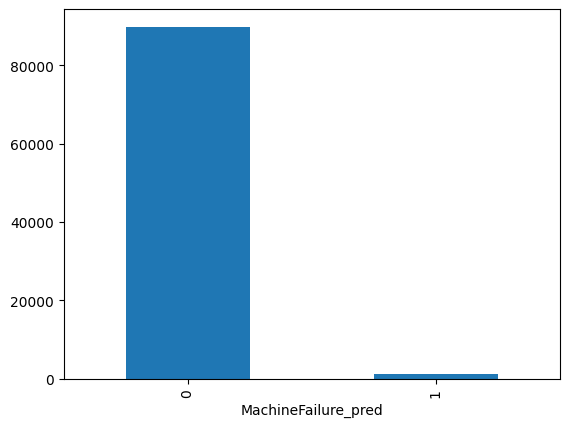

In [67]:
df_final['MachineFailure_pred'].value_counts().plot(kind='bar')

In [68]:
df_final.to_csv("LogisticResults.csv", index=False)